# Practical Assignment 3

Recurrent neural networks can deal with sequential data (timeseries). In this assignment a recurrent neural network is implemented which computes the current outpus as the sum of the two previous inputs. 

First we deal with the imports:

In [2]:
from __future__ import division

import numpy as np
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import chainer.training as training
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from chainer import iterators
from chainer.cuda import to_cpu

### Implementation of RNN


In [49]:
class RNN(Chain):
    """
    
    RNN implementation consisting of 1 lstm layer 
    and one fully connected layer
    
    """
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None,1) 
            self.linear = L.Linear(None,1)
                
    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        # Given the current input compute the sum
        h = self.lstm(x)
        y = self.linear(h)
        return y
                

class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        return loss

The next class shows the backprop through time method. This is the main training method.

In [50]:
class BPTTUpdater(chainer.training.StandardUpdater):

    def __init__(self, train_iter,  optimizer, bprop_len, rnn):
        super(BPTTUpdater, self).__init__(train_iter, optimizer)
        self.bprop_len = bprop_len

    # The core part of the update routine can be customized by overriding.
    def update_core(self):
        train_loss = []
        test_loss = []
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        count = 0
        total_loss = 0
        # Progress the dataset iterator for bprop_len 
        for i in range(self.bprop_len):
            count += 1
            # Get the next batch 
            batch = train_iter.__next__()
            
            x, t = self.converter(batch)
            model.reset_state()
            # Compute the loss at this time step and accumulate it
            loss = optimizer.target(chainer.Variable(x), chainer.Variable(t))
            total_loss += loss
            if count % 30 == 0:
                optimizer.target.cleargrads()  # Clear the parameter gradients
                total_loss.backward()  # Backprop
                total_loss.unchain_backward()
                optimizer.update()  # Update the parameters
                train_loss.append(loss.data)
                #calculate test loss
                test_batch = test_iter.next()
                xtest, ttest = self.converter(test_batch)
                # Forward the test data
                loss_test = regressor(xtest, ttest)
                test_loss.append(loss_test.data)
        return train_loss, test_loss

#### Data creator method, as given in the course.

In [51]:
def create_data(n=3000):
    X = np.random.rand(n, 1).astype('float32')
    T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n, 1])

    return TupleDataset(X, T)

#### Visualisation function

In [52]:
def visualize_loss(train_loss, test_loss, nr_epochs=20):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(10, 8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, nr_epochs+1, 1)
    ax.set_xticks(xticks)
    epochs = range(1, nr_epochs + 1)
    train, = plt.plot(epochs, train_loss, 'b', label='train loss')
    test, = plt.plot(epochs, test_loss, 'r', label='test loss')
    plt.legend([train, test], ['train loss', 'test loss'])
    plt.show()

#### The training loop 
The training loop runs for 10 epochs 

In [53]:
#set the number of epochs
nr_epochs = 20
#retrieve the data
train_data = create_data()
test_data = create_data()
inputs, labels = np.array([tup[0] for tup in test_data]), np.array([tup[1] for tup in test_data])

#instantiating iterators
train_iter = iterators.SerialIterator(train_data, 1)
test_iter = iterators.SerialIterator(test_data, 1,repeat=False, shuffle=False)

#instantiating a model
model = RNN()
regressor = Regressor(model)

#choosing an optimizer
optimizer = chainer.optimizers.SGD(lr=0.02)
optimizer.setup(regressor)
updater = BPTTUpdater(train_iter, optimizer,3000, model)
train_loss, test_loss = [], []
#update network (evaluation is done within the loop)
for i in range(nr_epochs):
    loss_train, loss_test = updater.update_core()
    print(np.mean(loss_train), np.mean(loss_test))
    train_loss.append(np.mean(loss_train))
    test_loss.append(np.mean(loss_test))
    model.reset_state()

(0.098234721, 0.10301366)
(0.11271052, 0.094352134)
(0.095374815, 0.085402824)
(0.10284519, 0.10243623)
(0.098582745, 0.081461437)
(0.09059675, 0.10794505)
(0.07991337, 0.10584252)
(0.10286374, 0.10032232)
(0.10160837, 0.090240248)
(0.095631219, 0.0962971)
(0.07739301, 0.093731977)
(0.10513683, 0.095450334)
(0.084796913, 0.096118815)
(0.089413144, 0.086323023)
(0.082256973, 0.11677773)
(0.088945024, 0.097451247)
(0.079421066, 0.092322826)
(0.075663067, 0.10438094)
(0.11127152, 0.11893801)
(0.08374963, 0.083748862)


### Part 1: Training and Test loss as a function of epoch number

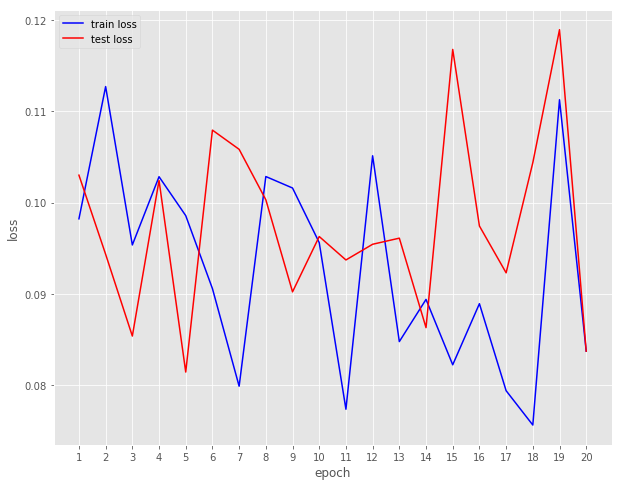

In [54]:
### visualise train and test loss for 20 epochs
visualize_loss(train_loss, test_loss, nr_epochs)

### Part 2: Actual vs. predicted output

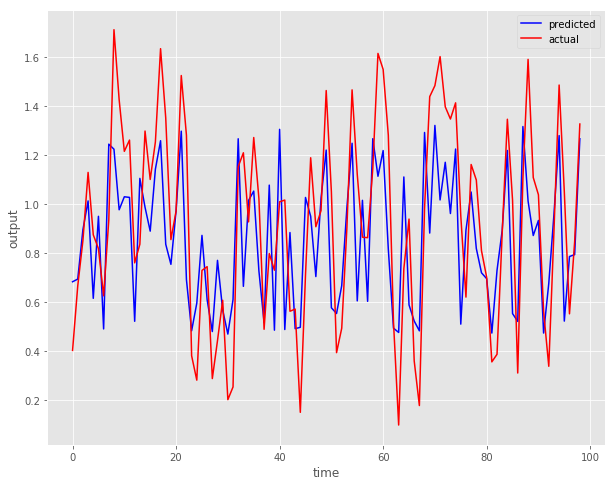

In [55]:
matplotlib.style.use('ggplot')
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111)
ax.set_xlabel('time')
ax.set_ylabel('output')
new_inputs = inputs[1:100]
pred_inputs = model(new_inputs).data
actual_inputs = labels[1:100]
predicted, = plt.plot(pred_inputs, 'b', label='predicted')
actual, = plt.plot(actual_inputs, 'r',label='actual')
plt.legend([predicted, actual], ['predicted', 'actual'])
plt.show()
